# Sentiment Analysis and Clustering of Pubmed Abstracts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime,re, string, timeit, nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import sentiwordnet as swn
from nltk.corpus.reader.wordnet import WordNetError
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from  sklearn.externals import joblib
from nltk.tag import StanfordNERTagger
from nltk.tag.stanford import CoreNLPNERTagger
from nltk.tag.stanford import StanfordNERTagger
import polyglot
from SentimentTrendPlot import plot_sentiment_trends
from PubmedSentimentFunctions import abs_tagger,map_pos,tag_get_score
%matplotlib inline
from scipy.cluster.hierarchy import dendrogram, linkage
#np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [2]:
#loading in data
df = pd.read_csv("pubmed_cleaned.csv")
df = df[df['Clean_Abstract'].isnull() == False]

# get pre-scored dataset
scored = True
if scored:
    df = pd.read_csv("pubmed_cleaned_scored.csv")

/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1451: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._converter.TimeSeries_DateLocator'>
  str(type(self)))


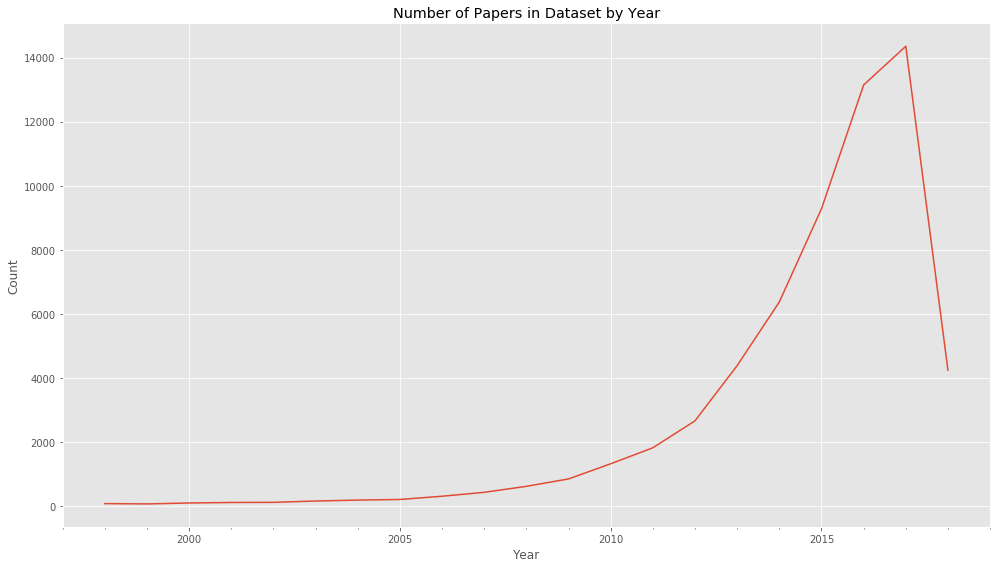

In [4]:
import matplotlib.dates as mdates

plt.style.use('ggplot')

years = mdates.YearLocator()   # every year

#fig,ax = plt.subplots(figsize=(17,8))

df['Year'] = pd.to_datetime(df.Year, format='%Y')

grouped = df.groupby(by=[df['Year']])['Article_title'].count()

plt.figure(figsize=(14,8))
#ax.figure(figsize=(18,8))
grouped.plot()
#plt.xlim(1997,2018)
plt.title("Number of Papers in Dataset by Year")
plt.ylabel('Count')
plt.xlabel('Year')
plt.tight_layout()
#plt.xlim([datetime.date(1997, 1, 1), datetime.date(2019, 1, 1)])
#plt.xticks(np.arange(21), (1997,1998,1999,2000,2001,2002,2003,2004,
#                           2005,2006,2007,2008,2009,2010,2011,2012,
#                           2013,2014,2015,2016,2017,2018))


#ax.set_xticks()
plt.locator_params(axis='x', nbins=10)

#plt.xaxis.set_major_locator(years)
#plt.xaxis.set_major_formatter(yearsFmt)


In [5]:
df['disease'].unique()

array(['fever', 'diabetes type 2', 'pancreatic cancer', 'alzheimers',
       'lupus', 'parkinsons', 'dementia', 'breast cancer',
       'high blood pressure', 'heart disease', 'lymphoma',
       'clinical depression', 'bipolar disorder', 'arthritis',
       'lime disease', 'amyotrophic lateral sclerosis', 'obesity',
       'acquired immunodeficiency syndrome', 'thyroid cancer',
       'kidney failure', 'multiple sclerosis', 'lung cancer', 'melanoma',
       'Non-melanoma skin cancer', 'prostate cancer', 'Colorectal cancer',
       'non-hodgkin lymphoma', 'insomnia', 'anxiety disorder', 'dystonia',
       'influenza', 'stroke', 'hepatitis b'], dtype=object)

In [10]:
df['Clean_Abstract'][0]

'fever relatively common worsens neurologic injury aneurysmal subarachnoid hemorrhage sah.aim study wa display time course body temperature identify predictive factor fever sah evaluate impact delayed cerebral ischemia dci clinical outcome.four hundred twelve patient sah ruptured aneurysm treated institution january december analyzed retrospectively.febrile group wa defined patient maximal temperature ≥38.0°c consecutive day day within week sah remaining patient comprised afebrile group.impact fever dci clinical outcome wa assessed.anterior communicating artery aneurysm hunt hess grade sah sum score intraventricular hemorrhage sum score body mass index independent predictive factor fever sah.larger sah fever independent risk factor dci.worse hunt hess grade concomitant intracerebral hemorrhage dci old age fever independent risk factor unfavorable outcome.predictor fever sah worse clinical status admission larger sah intraventricular hemorrhage anterior communicating artery aneurysm gre

In [16]:
#df = df[df['disease']=='alzheimers'].reset_index()

#### Some more pre-processing- gathering the named entities

In [21]:
st = StanfordNERTagger('/Users/jacobdodd/Desktop/PhotoPharmicsProject/stanford-ner-2018-02-27/classifiers/english.all.3class.distsim.crf.ser.gz',
                      '/Users/jacobdodd/Desktop/PhotoPharmicsProject/stanford-ner-2018-02-27/stanford-ner.jar')

/anaconda3/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [20]:
#st.tag(df['abstract'][0].split())

In [8]:
from polyglot.text import Text

In [9]:
df['abstract'][3]

'The contribution of cardiovascular disease (CV) and cerebrovascular disease to the risk for late-onset Alzheimer disease (LOAD) has been long debated. Investigations have shown that antecedent CV risk factors increase the risk for LOAD, although other investigations have failed to validate this association.To study the contribution of CV risk factors (type 2 diabetes, hypertension, and heart disease) and the history of stroke to LOAD in a data set of large families multiply affected by LOAD.The National Institute on Aging Late-Onset Alzheimer Disease/National Cell Repository for Alzheimer Disease family study (hereinafter referred to as NIA-LOAD study) is a longitudinal study of families with multiple members affected with LOAD. A multiethnic community-based longitudinal study (Washington Heights-Inwood Columbia Aging Project [WHICAP]) was used to replicate findings. The 6553 participants in the NIA-LOAD study were recruited from 23 US Alzheimer disease centers with ongoing data colle

In [7]:
text = Text(df['abstract'][3])

NameError: name 'Text' is not defined

In [11]:
text.entities

[I-ORG(['Investigations']),
 I-ORG(['LOAD.The', 'National']),
 I-ORG(['NIA']),
 I-ORG(['Washington']),
 I-LOC(['Washington', 'Heights']),
 I-LOC(['Inwood']),
 I-ORG(['Inwood', 'Columbia', 'Aging']),
 I-ORG(['NIA']),
 I-ORG(['Columbia', 'University']),
 I-PER(['APOE', 'ε4']),
 I-ORG(['NIA'])]

#### Creating the TF-IDF matrix

A TF-IDF matrix is:  ___

Steps:

1) count word occurences by document

2) transform that into a docment-term matrix, where the rows are the documents and the columns each represent 1 word

3) apply erm frequency-inverse doc frequency weighting- words that occure frequently within a document but not frequently within all of the documents (corpus) recieve higher weights, as they are assumed to have higher relevance in doc

In [11]:
# key args:
# max_df: maximum frequency within the documents a given
#    feature can have to be used in the tfi-idf matrix
# min_idf: number or %  of of documents the term must be in to be considered in matrix
# ngram_range - 1 for unigram (1 word) 2 for bigram, etc.

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
#%time 
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Clean_Abstract'])

print(tfidf_matrix.shape)

(60828, 1903)


In [12]:
# get terms in matrix
terms = tfidf_vectorizer.get_feature_names()

In [ ]:
# get cosine similarity
#dist = 1 - cosine_similarity(tfidf_matrix)

In [13]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Article_title', 'Date',
       'ISSN', 'PMID', 'abstract', 'authors', 'disease', 'journal_title',
       'keywords', 'language', 'med_type', 'Clean_Date', 'Month', 'Year',
       'Day', 'Clean_Abstract', 'abs_scores'],
      dtype='object')

#### melting the tf-idf matrix into format for wordcloud

In [ ]:
tfidf = pd.DataFrame(tfidf_matrix.todense(), index=df.index, columns=tfidf_vectorizer.get_feature_names())
tfidf['PMID'] = df.PMID

In [42]:
#tfidf[tfidf['abnormal'] > 0]
tfidf.head()

,ability,able,abnormal,abnormality,absence,access,accompanied,according,account,accumulation,...,year,year age,year follow,year old,year patient,year year,yielded,young,younger,PMID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29548963
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29419375
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29133009
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29078933
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04243,0.097566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28951104


In [44]:
tfidf_long = pd.melt(tfidf.reset_index(), 
                     id_vars=['level_0','PMID'], 
                     value_name='tfidf').query('tfidf > 0')

In [45]:
tfidf_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4079366 entries, 29 to 115755636
Data columns (total 4 columns):
level_0     int64
PMID        int64
variable    object
tfidf       float64
dtypes: float64(1), int64(2), object(1)
memory usage: 155.6+ MB


In [46]:
tfidf_long[tfidf_long['variable'] == 'ability'].head()

,level_0,PMID,variable,tfidf
29,29,27992852,ability,0.086615
60,60,28858264,ability,0.071428
86,86,28159951,ability,0.060846
108,108,26957385,ability,0.120417
171,171,27544342,ability,0.067527


In [48]:
mean_tfidf = pd.DataFrame(tfidf_long.groupby("variable",group_keys=False)['tfidf'].mean())

In [52]:
mean_tfidf.reset_index(inplace=True)

In [54]:
mean_tfidf.to_csv("mean_tfidf_corpus.csv")

# Hierarchical Clustering - Dendrogram

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [39]:
link = ward(dist)

ValueError: setting an array element with a sequence.

In [ ]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    link,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

## Option 1: Kmeans-clustering

In [22]:
#joblib.dump(km,  'pb_doc_cluster.pkl')
km = joblib.load('pb_doc_cluster.pkl')
clusters = km.labels_.tolist()

In [26]:
n_clusters = 8

km = KMeans(n_clusters=n_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [23]:
df['cluster'] = clusters

In [24]:
df['cluster'].value_counts()

0    28451
1     9523
3     8783
6     3917
4     3242
5     3202
2     1917
7     1793
Name: cluster, dtype: int64

In [29]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % terms[ind], end='')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    titles = df[df['cluster']==i]['Article_title'].values.tolist()
    print(titles[0:11])
    print()
    print()

Top terms per cluster:

Cluster 0 words: patient wa disease stroke obesity study

Cluster 0 titles:['Predictive Factors of Fever After Aneurysmal Subarachnoid Hemorrhage and Its Impact on Delayed Cerebral Ischemia and Clinical Outcomes.', 'Tri-phasic fever in dengue fever.', 'Periconceptional maternal fever, folic acid intake, and the risk for neural tube defects.', 'Neutropenic Fever.', 'Detection of human parvovirus B19 in serum samples from children under 5 years of age with rash-fever illnesses in the Democratic Republic of the Congo.', 'Temporal variation in confirmed diagnosis of fever-related malarial cases among children under-5\xa0years by community health workers and in health facilities between years 2013 and 2015 in Siaya County, Kenya.', 'Evaluation of fever in the immediate post-operative period following shoulder arthroplasty.', '2 receptor in LPS-induced fever in rats.', 'Evaluation of fever in the emergency department.', 'Adequacy of initial evaluation of fever in long

In [100]:
import json

## Option 1: create tokens for each abstract and then POS tag, then get sentiment for each term

In [36]:
test_ab = df['Clean_Abstract'][1]
print(tag_get_score(test_ab,sentences=True,weights=None))
print(tag_get_score(test_ab))

-4.318452380952381
-4.068452380952381


In [37]:
df['abs_scores'] = df['Clean_Abstract'].apply(lambda x: tag_get_score(x,sentences=True))
#df['perc_tagged'] = df['Clean_Abstract'].apply(lambda x: tag_get_score(x)[1])

In [38]:
df['abs_scores'].describe()

count    60828.000000
mean        -0.271254
std          1.995901
min        -20.924213
25%         -1.164714
50%         -0.057526
75%          0.825151
max         12.664881
Name: abs_scores, dtype: float64

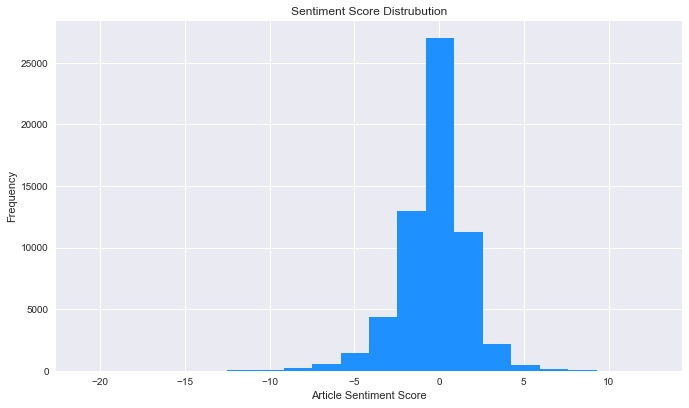

In [32]:
plt.style.use("seaborn")
plt.figure(figsize=(10,6))
plt.hist(df['abs_scores'],bins=20,color='dodgerblue')
plt.ylabel("Frequency")
plt.xlabel("Article Sentiment Score")
plt.title("Sentiment Score Distrubution")
plt.show()

In [55]:
df[df['abs_scores']<0.0].count()

Unnamed: 0        31418
Unnamed: 0.1      31418
Unnamed: 0.1.1    31418
Article_title     31418
Date              31418
ISSN              31408
PMID              31418
abstract          31418
authors           30312
disease           31418
journal_title     31418
keywords          18464
language          31418
med_type          17421
Clean_Date        31418
Month             31418
Year              31418
Day               31418
Clean_Abstract    31418
abs_scores        31418
dtype: int64

In [2]:
#df.to_csv("pubmed_cleaned_scored.csv")
df = pd.read_csv("pubmed_cleaned_scored.csv")

In [3]:
df[df['abs_scores'] == df['abs_scores'].max()]['abstract']

55609    During the 2013-2014 influenza season, Public ...
Name: abstract, dtype: object

In [4]:
df[df['abs_scores'] > 10]['abstract'][10243]

"To validate the Fullerton Advanced Balance (FAB) Scale for patients with idiopathic Parkinson disease (PD); and to compare the FAB Scale with the Mini-Balance Evaluation Systems Test (Mini-BESTest) and Berg Balance Scale (BBS).Observational study to assess concurrent validity, test-retest, and interrater reliability of the FAB Scale in patients with PD and to compare the distribution of the scale with the Mini-BESTest and BBS.University hospital in an urban community.Patients with idiopathic PD (N=85; Hoehn and Yahr stages 1-4).Not applicable.FAB Scale, Mini-BESTest, BBS, timed Up and Go test, Unified Parkinson's Disease Rating Scale, and visual analog scale.Interrater (3 raters) and test-retest (3±1 d) reliability were high for all scales (ICCs≥.95). The FAB Scale was highly correlated with the Mini-BESTest (Spearman ρ=.87) and timed Up and Go test item of the Mini-BESTest (Spearman ρ=.83). In contrast with the BBS, the FAB Scale and Mini-BESTest have only minimal ceiling effects. Th

In [6]:
#plt.hist(df['perc_tagged'],bins=20)

In [7]:
df.groupby('disease',group_keys=False)['abs_scores'].mean().sort_values()

disease
insomnia                             -3.373999
obesity                              -2.489965
hepatitis b                          -1.675548
anxiety disorder                     -1.489538
dementia                             -1.263741
arthritis                            -1.252598
fever                                -0.674395
multiple sclerosis                   -0.566321
clinical depression                  -0.440472
lupus                                -0.419348
thyroid cancer                       -0.391547
non-hodgkin lymphoma                 -0.254443
diabetes type 2                      -0.213794
acquired immunodeficiency syndrome   -0.207334
lung cancer                          -0.135541
kidney failure                       -0.129999
amyotrophic lateral sclerosis        -0.070283
bipolar disorder                     -0.035790
dystonia                              0.017155
lymphoma                              0.049432
pancreatic cancer                     0.080933
Non-m

#### Plotting Sentiment over time for disease

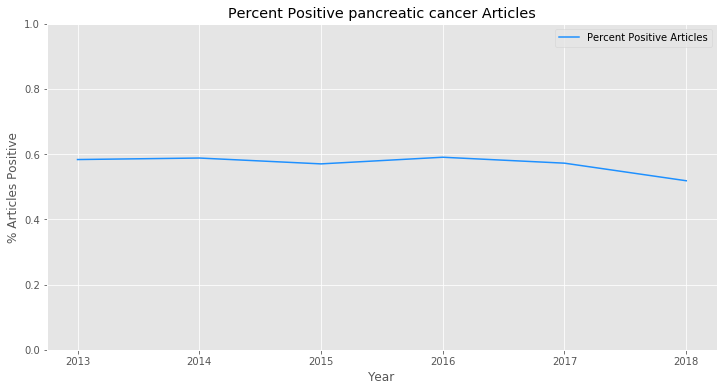

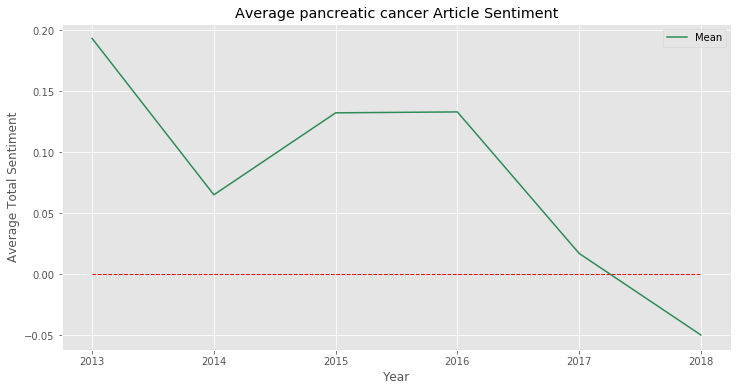

In [4]:
yearly = plot_sentiment_trends(df=df,term='pancreatic cancer',style='ggplot')

In [15]:
yearly

,index,group_date,min_pos,max_pos,mean_pos,count_pos,min_neg,max_neg,mean_neg,count_neg,perc_pos,min,max,mean,count
0,3,2010,0.176736,2.379924,0.867942,7.0,-3.546474,-0.037662,-1.270021,13.0,0.350000,-3.546474,2.379924,-0.521734,20
1,4,2011,0.005949,1.546925,0.732042,11.0,-4.389520,-0.047484,-1.569202,24.0,0.314286,-4.389520,1.546925,-0.845954,35
2,5,2012,0.051799,3.124369,0.889477,19.0,-10.758923,-0.002133,-2.008809,41.0,0.316667,-10.758923,3.124369,-1.091019,60
3,6,2013,0.000000,4.736169,0.937404,65.0,-5.427473,-0.041477,-1.400847,83.0,0.439189,-5.427473,4.736169,-0.373912,148
4,7,2014,0.000000,3.778248,1.043899,135.0,-10.345694,-0.003842,-1.460556,169.0,0.444079,-10.345694,3.778248,-0.348380,304
5,8,2015,0.008185,3.750401,0.841868,149.0,-9.452525,-0.002976,-1.441046,190.0,0.439528,-9.452525,3.750401,-0.437641,339
6,9,2016,0.000000,3.724242,0.927258,168.0,-12.153030,-0.016306,-1.478747,224.0,0.428571,-12.153030,3.724242,-0.447602,392
7,10,2017,0.000000,3.710992,0.956575,222.0,-13.398730,-0.014484,-1.431239,266.0,0.454918,-13.398730,3.710992,-0.344979,488
8,11,2018,0.000000,3.568317,0.926253,83.0,-8.287943,-0.008333,-1.470421,90.0,0.479769,-8.287943,3.568317,-0.320572,173


In [131]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [125]:
#disease = 'breast cancer'

#plot_df = df[df['disease']== disease][['abs_scores','Clean_Date']]
#plot_df = df[['abs_scores','Clean_Date','disease']]

#aids_df.set_index('Clean_Date',inplace=True,drop=True)
#aids_df['Clean_Date'], aids_df['Clean_Date'] = aids_df['Clean_Date'].dt.year, \
#aids_df['Clean_Date'].dt.month

#plot_df['group_date'] = plot_df['Clean_Date'].apply(str).apply(lambda x: x.split('-')[0]) \
                            #+ "-"+ plot_df['Clean_Date'].apply(str).apply(lambda x: x.split('-')[1]) 

#yearly = pd.DataFrame(plot_df.groupby(['group_date'],group_keys=False)['abs_scores'].agg(['min','max','mean','count']))

#n_years = plot_df['group_date'].nunique()
#zeros = [0]*n_years
#aids_df.head()

#plt.figure(figsize=(12,6))
#plt.plot(yearly['Mean'])
#plt.title("Average {} Article Sentiment".format(disease))
#plt.xlabel("Year")
#plt.ylabel("Average Total Sentiment")
#plt.ylim(-2,5)
#plt.plot(zeros,'--',linewidth=1,color='red')

#### Melting the cleaned abstract to tokens

In [ ]:
abst_tokens = pd.DataFrame(df['Clean_Abstract'].str.split(' ',expand=True),index=df.index)
#abst_tokens['Title'] = df['Article_title']

abst_tokens['article_id'] = abst_tokens.index

abst_df = pd.melt(abst_tokens, id_vars=['article_id'])

abst_df = abst_df.sort_values(by=['article_id','variable'])

abst_df.dropna(subset=['value'],inplace=True)

print(abst_df.head())

#### Creating the document-term matrix

In [ ]:
vec = CountVectorizer(decode_error='ignore')
X = vec.fit_transform(df['Clean_Abstract'])
abst = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(abst.head())


#### Getting most common words in dataset

In [ ]:
s = abst.sum(axis=0)#.sort(ascending=False, inplace=False)

In [ ]:
s.sort_values(ascending=False).head(100)

In [ ]:
plt.hist(s.values,bins=np.arange(min(s.values), max(s.values) + 10,10))
plt.xlim(0,250)